# Swath profile of thermochron & cooling vs distance to Alpine thrust front

make figures of outcrop and borehole fission track and vitrinite reflectance data vs distance to subalpine thrust front and distance along-strike   of the thrust front + panel 
with surface elevation, elevation OMM, and elevation basement with distance + panel with post 12 Ma cooling rate based on thermochron data

## Install packages missing in standard google colab setup

In [19]:
!pip install gdal
!pip install fiona

In [2]:
import os
import math
import pdb

import pandas as pd
import numpy as np

import shapely.geometry
import matplotlib.pyplot as pl
import scipy.stats

import matplotlib.cm

import fiona

#import osgeo.gdal

from collections import OrderedDict

#import useful_functions
#import pyGISlib


## Parameters:

In [3]:
# distance variable to use for x-axis
#
#distance_var = 'distance_thrust_front_perpendicular'

degree_symbol = chr(176)

scatter_size = 50
alpha = 0.8
fs = 'xx-small'
vmin_aft = 0
vmax_aft = 50

vmin_vr = 0.2
vmax_vr = 1.0

cmap = matplotlib.cm.jet

## Data files:

In [4]:
fn_vr = "thermochron_data/vitrinite_reflectance_PhD_thesis_Schegg.csv"
fn_aft = "thermochron_data/thermochron_compilation_molasse_basin.csv"
#fn_boreholes = "../../Databases/thermochron/Molasse_basin/thermochron_summary_boreholes_MB.csv"
fn_boreholes = "thermochron_data/borehole_locations_AFT.csv"
fn_aft_b = "thermochron_data/aft_data_boreholes.csv"
fn_vr_b = "thermochron_data/vitrinite_reflectance_boreholes.csv"
fn_strat = "data/well_stratigraphy.csv"
#fn_cool = '../pybasin/model_output/MB/final_results_10aug2015/' \
#          'model_results_borehole_and_surface_24aug2015_cooling_and_exhumation_summary.csv'
fn_cool = 'data/model_results_borehole_and_surface_24aug2015_cooling_and_exhumation_summary.csv'
fn_locs = 'thermochron_data/thermochron_sample_locs.csv'
fnr = 'data/rock_uplift_Yanites2013_mod.csv'

## define filenames GIS files:

In [5]:
# Elevation
fn_dem = 'gis_datasets/DHM200.tif'
# OMM outcrop raster
fn_omm = 'gis_datasets/OMM_raster_swiss_coords.tif'
# Depth base Cenozoic raster
fn_cen = 'gis_datasets/depth_cenozoic_raster.tif'

# Alpine thrust front:
shp_fn = "gis_datasets/alpine_thrust_front_continuous_singlepart.shp"



## Define some functions that we need later:

In [6]:
from lib.geospatial_functions import *

## Load datasets

In [7]:
df_vr = pd.read_csv(fn_vr)
df_aft = pd.read_csv(fn_aft)
#df_b = pd.read_csv(fn_boreholes)
df_ab = pd.read_csv(fn_aft_b)
df_vrb = pd.read_csv(fn_vr_b)
df_strat = pd.read_csv(fn_strat)
df_cool = pd.read_csv(fn_cool)
df_locs = pd.read_csv(fn_locs)
df_river = pd.read_csv(fnr)

## Clean input datasets

In [8]:
# drop altered outcrop vr samples
df_vr = df_vr[df_vr['A'] < 2]
if df_vr.index.name != 'sample_id':
    df_vr = df_vr.set_index('sample_id')

# drop thermochron data without coordinates
df_aft = df_aft.dropna(subset=['long'])

# and drop non-molasse samples
df_aft = df_aft[df_aft['include_in_compilation'] == 'y']

# drop population data from dataframe
df_ab = df_ab[df_ab['data_type'] == 'central_age']

# read borehole locations
dfb = pd.read_csv(fn_boreholes)

# correct borehole names
#dfb['well'] = [b.split('-')[0].split(' ')[0]
#               for b in dfb['borehole'].tolist()]
dfb = dfb.set_index('borehole')

# find locations for cooling/exhumation estimates
df_locs = df_locs.set_index('location')
df_cool['location'] = df_cool['well']
df_cool = df_cool.set_index('location')
df_cool = df_cool.join(df_locs, rsuffix='_loc')

# make 1 dataframe with borehole AFT data
df_ab['location'] = df_ab['well']
df_ab = df_ab.set_index('location')
df_ab = df_ab.join(dfb)


# and 1 with all vr data
df_vrb['location'] = df_vrb['well']
df_vrb = df_vrb.set_index('location')
df_vrb = df_vrb.join(dfb)

#
df_strat['location'] = df_strat['well']
df_strat = df_strat.set_index('location')
df_strat = df_strat.join(dfb)

# convert rock uplift due to drainage reorg to approx cooling rates
geothermal_gradient = 30.0 / 1000.0
#surface_temp = 10.0
df_river['cooling'] = df_river['rock_uplift'] * geothermal_gradient

## Load GIS datasets:

In [9]:
# load dem
dem, dimensions, origin, cellsize, nodata, projection = read_raster_file(fn_dem)
ny, nx = dem.shape

# load OMM outcrops
omm_outcrop, dimensions1, origin1, cellsize1, nodata1, projection1 = read_raster_file(fn_omm)

# load basement depths
depth_cen, dimensions2, origin2, cellsize2, nodata2, projection2 = read_raster_file(fn_cen)

# ALpine thrust front shapefile
lss = []
shp = fiona.open(shp_fn)
for segment in shp:
    lss.append(shapely.geometry.shape(segment['geometry']))
thrust_front = shapely.geometry.MultiLineString(lss[0])
shp.close()

## calculate distance to thrust front for thermochron data

### generate point shape from sample locs

todo: use geopandas to do this:

In [10]:
# clean up datapoints with no coordinates
df_ab = df_ab.dropna(subset=['x_coord_swiss_grid', 'y_coord_swiss_grid'])
df_strat = df_strat.dropna(subset=['x_coord_swiss_grid', 'y_coord_swiss_grid'])



aft_pts = shapely.geometry.MultiPoint(list(zip(df_aft['x_swiss_grid'].values,
                                               df_aft['y_swiss_grid'].values)))

vr_pts = shapely.geometry.MultiPoint(list(zip(df_vr['x_swiss_coords'].values,
                                         df_vr['y_swiss_coords'].values)))

b_pts = shapely.geometry.MultiPoint(list(zip(dfb['x_coord_swiss_grid'].values,
                                        dfb['y_coord_swiss_grid'].values)))

ab_pts = shapely.geometry.MultiPoint(list(zip(df_ab['x_coord_swiss_grid'].values,
                                         df_ab['y_coord_swiss_grid'].values)))

vrb_pts = shapely.geometry.MultiPoint(list(zip(df_vrb['x_coord_swiss_grid'].values,
                                          df_vrb['y_coord_swiss_grid'].values)))

strat_pts = shapely.geometry.MultiPoint(list(zip(df_strat['x_coord_swiss_grid'].values,
                                        df_strat['y_coord_swiss_grid'].values)))

cool_pts = shapely.geometry.MultiPoint(list(zip(df_cool['x_swiss_grid'].values,
                                           df_cool['y_swiss_grid'].values)))

### Calculate distances for point datasets

In [11]:
pt_datas = [aft_pts, vr_pts, b_pts, ab_pts, vrb_pts, strat_pts, cool_pts]
dfs = [df_aft, df_vr, dfb, df_ab, df_vrb, df_strat, df_cool]

for pt_data, df in zip(pt_datas, dfs):

    distance_thrust_front_corr, distances, distances_parallel = \
        find_distance_to_front(pt_data, thrust_front, 210)
    df['distance_thrust_front'] = distances
    df['distance_thrust_front_perpendicular'] = distance_thrust_front_corr
    df['distance_thrust_front_parallel'] = distances_parallel
    #fn_adj = fn_aft[:-4] + '_with_thrust_dist.csv'
    #df_aft.to_csv(fn_adj, index=False)

## Calculate distance to thrust front for GIS datasets

In [12]:
x_raster, y_raster = get_raster_coordinates(dimensions, cellsize, origin)

sampling_int = 10
a, b = dem.shape

#x_dem_init = np.ravel(x_raster[::sampling_int, ::sampling_int])
#y_dem_init = np.ravel(y_raster[::sampling_int, ::sampling_int])
#z_dem_init = np.ravel(dem[::sampling_int, ::sampling_int])
#omm_outcrop_array = np.ravel(omm_outcrop[::sampling_int, ::sampling_int])

print('selecting dem values')
limit_dem_pts = True
if limit_dem_pts is True:
    max_dem_pts = 1e5
    max_dem_samples = int(max_dem_pts)
    print('selecting %i out of %i dem pts' % (max_dem_pts, len(x_raster.ravel())))
    selection = np.random.randint(0, len(np.ravel(x_raster)), max_dem_samples)
    x_dem_init = np.ravel(x_raster)[selection]
    y_dem_init = np.ravel(y_raster)[selection]
    z_dem_init = np.ravel(dem)[selection]
    omm_outcrop_array = np.ravel(omm_outcrop)[selection]
    depth_cen_array = np.ravel(depth_cen)[selection]
    #pass
else:
    x_dem_init = np.ravel(x_raster)
    y_dem_init = np.ravel(y_raster)
    z_dem_init = np.ravel(dem)
    omm_outcrop_array = np.ravel(omm_outcrop)
    depth_cen_array = np.ravel(depth_cen)

# remove nodata from dem
ind = z_dem_init != nodata
x_dem = x_dem_init[ind]
y_dem = y_dem_init[ind]
z_dem = z_dem_init[ind]

# and from omm outcrop array
#om_outcrop_array = np.ravel(omm_outcrop[::sampling_int, ::sampling_int])
ind = (omm_outcrop_array != nodata1) & (omm_outcrop_array > 0) & (z_dem_init != nodata)
x_omm = x_dem_init[ind]
y_omm = y_dem_init[ind]
omm_outcrop_array = omm_outcrop_array[ind]
z_dem_omm = z_dem_init[ind]

ind = depth_cen_array != nodata2
x_cen = x_dem_init[ind]
y_cen = y_dem_init[ind]
depth_cen_array = depth_cen_array[ind]

print('finding distances for dem points, this may take a while.....')

print('dem:')
dem_pts = shapely.geometry.MultiPoint(list(zip(x_dem, y_dem)))
distances_perpendicular_dem, distances, distances_parallel_dem = find_distance_to_front(dem_pts, thrust_front, 210)

print('omm:')
omm_pts = shapely.geometry.MultiPoint(list(zip(x_omm, y_omm)))
distances_perpendicular_omm, distances, distances_parallel_omm = find_distance_to_front(omm_pts, thrust_front, 210)

print('depth cenozoic')
cen_pts = shapely.geometry.MultiPoint(list(zip(x_cen, y_cen)))
distances_perpendicular_cen, distances, distances_parallel_cen = find_distance_to_front(cen_pts, thrust_front, 210)
print('done')

selecting dem values
selecting 100000 out of 2313126 dem pts
finding distances for dem points, this may take a while.....
dem:
omm:
depth cenozoic
done


## Calculate cooling from surface VR data

In [13]:
vr_cool_params = [np.array([1.01145395,  4.14074848]),
                  np.array([1.01117741,  4.58244031]),
                  np.array([1.01089402,  5.21599505])]
labels = ['cooling_surface_vr_min',
          'cooling_surface_vr_best',
          'cooling_surface_vr_max']

ind_outcrop = df_vr['outcrop_or_borehole'] == 'outcrop'

vr_values = [df_vr['Rr'][ind_outcrop] - df_vr['s'][ind_outcrop],
             df_vr['Rr'][ind_outcrop],
             df_vr['Rr'][ind_outcrop] + df_vr['s'][ind_outcrop]]

for vr_cool_param, vr_value, label in zip(vr_cool_params, vr_values, labels):
    df_vr[label] = np.nan
    df_vr[label][ind_outcrop] = np.log(vr_value * vr_cool_param[1]) / np.log(vr_cool_param[0])

/var/folders/gq/fj_xhcmn3yg3gtst5_qj3drr0000gn/T/ipykernel_62707/1543043150.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_vr[label][ind_outcrop] = np.log(vr_value * vr_cool_param[1]) / np.log(vr_cool_param[0])
/var/folders/gq/fj_xh

## Merge vr and aft cooling estimates in one dataframe and save as csv file

In [14]:
df_vr['outcrop_or_borehole'] = 'outcrop'
df_vr['data_type'] = 'vr'

#
df_cool['outcrop_or_borehole'] = 'outcrop'
ind = df_cool['borehole'].notnull()
df_cool['outcrop_or_borehole'][ind] = 'borehole'

# store final cooling estimates
df_vr['cooling_min'] = df_vr['cooling_surface_vr_min']
df_vr['cooling_best'] = df_vr['cooling_surface_vr_best']
df_vr['cooling_max'] = df_vr['cooling_surface_vr_max']

df_cool['cooling_min'] = df_cool['cooling_at_est_min']
df_cool['cooling_best'] = df_cool['cooling_at_est_best']
df_cool['cooling_max'] = df_cool['cooling_at_est_max']

df_cool['data_type'] = 'aft'

df_cool['x_swiss_coords'] = df_cool['x_swiss_grid']
df_cool['y_swiss_coords'] = df_cool['y_swiss_grid']

# merge dataframes
df_all = pd.concat([df_cool, df_vr])

# reorder columns
cols_vr = df_vr.columns.tolist()
cols_cool = df_cool.columns.tolist()
cols = cols_vr + cols_cool

cols_unique = list(OrderedDict.fromkeys(cols))

fn_cool = 'data/cooling_estimates_MB.csv'

print('saving cooling estimates as %s' % fn_cool)

df_all.to_csv(fn_cool, index=True, index_label='well/sample')

saving cooling estimates as data/cooling_estimates_MB.csv


/var/folders/gq/fj_xhcmn3yg3gtst5_qj3drr0000gn/T/ipykernel_62707/3872175706.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cool['outcrop_or_borehole'][ind] = 'borehole'
/var/folders/gq/fj_xhcmn3yg3gtst5_qj3drr0000gn/T/ipykernel_62707

### Some figure parameters:

In [15]:
# rows in figure
nrows = 6

# marker size for errobars:
ms = 5

# formatting for boreholes
kwargs_borehole = {"ls": '-',
                   "color": 'lightgrey',
                   "zorder": 0,
                   "lw": 2}

# formatting for scatter plots
scatter_args = {"edgecolor": 'black', 'lw': 0.3, 'cmap': cmap, 's': 50}

# formatting for errorbars
errorbar_args = {'mec': 'black', 'lw': 0.3, 'ls': 'None', 'ms': ms}

# fontsize legend
leg_fs = 'small'

# show only every x dem values
thin_dem = 2

# position of the Jura edge on the paralell swath profile
x_jura = 250000

## Select which distance to show, perpendicular or parallel to thrust front

In [16]:
distance_vars = ['distance_thrust_front_perpendicular',
                 'distance_thrust_front_parallel']
#distance_var = distance_vars[0]

## Construct a figure of cooling estimates vs distance to the thrust front or along the thrust front 

well Altishofen, OMM from 25 to 322
well Chapelle, OMM from 17 to 112
well Herdern, OMM from 490 to 697
well Huenenberg, OMM from 372 to 1340
well Lindau, OMM from 400 to 515
well Linden, OMM from 27 to 888
well Romanens, OMM from 174 to 366
saving figure to subdirectory fig
well Altishofen, OMM from 25 to 322
well Chapelle, OMM from 17 to 112
well Herdern, OMM from 490 to 697
well Huenenberg, OMM from 372 to 1340
well Lindau, OMM from 400 to 515
well Linden, OMM from 27 to 888
well Romanens, OMM from 174 to 366
saving figure to subdirectory fig


/var/folders/gq/fj_xhcmn3yg3gtst5_qj3drr0000gn/T/ipykernel_62707/2341399607.py:268: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(legs, labels, loc='lower center', ncol=2, fontsize=leg_fs)


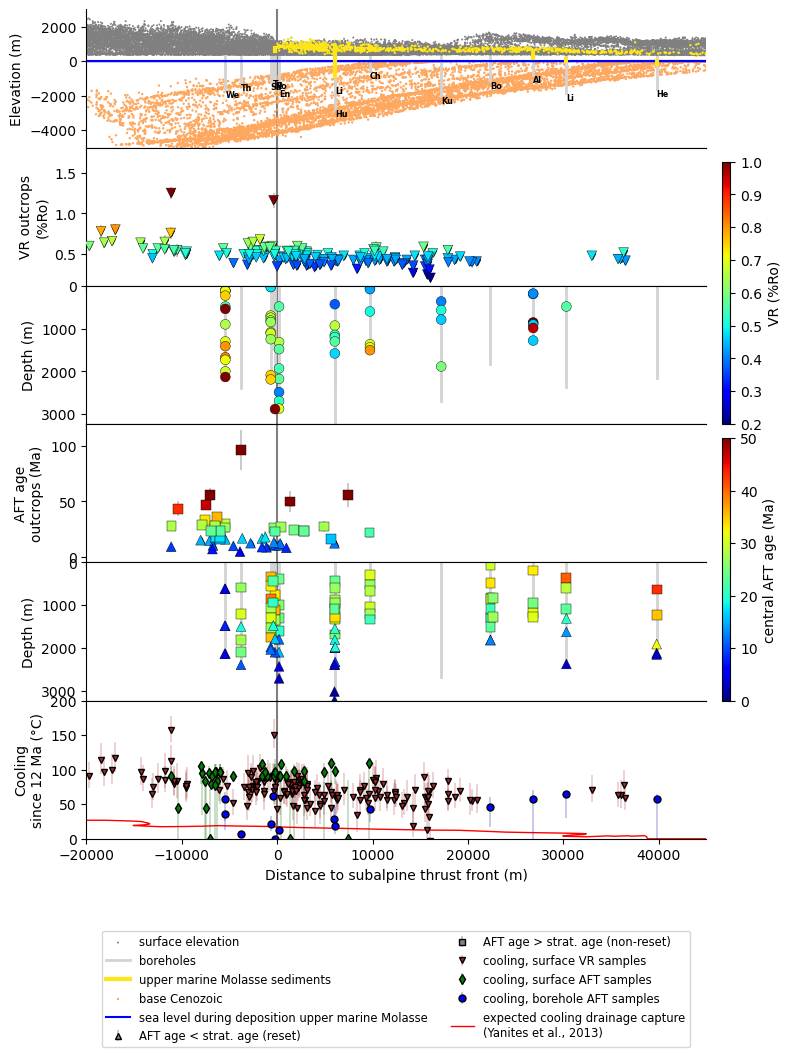

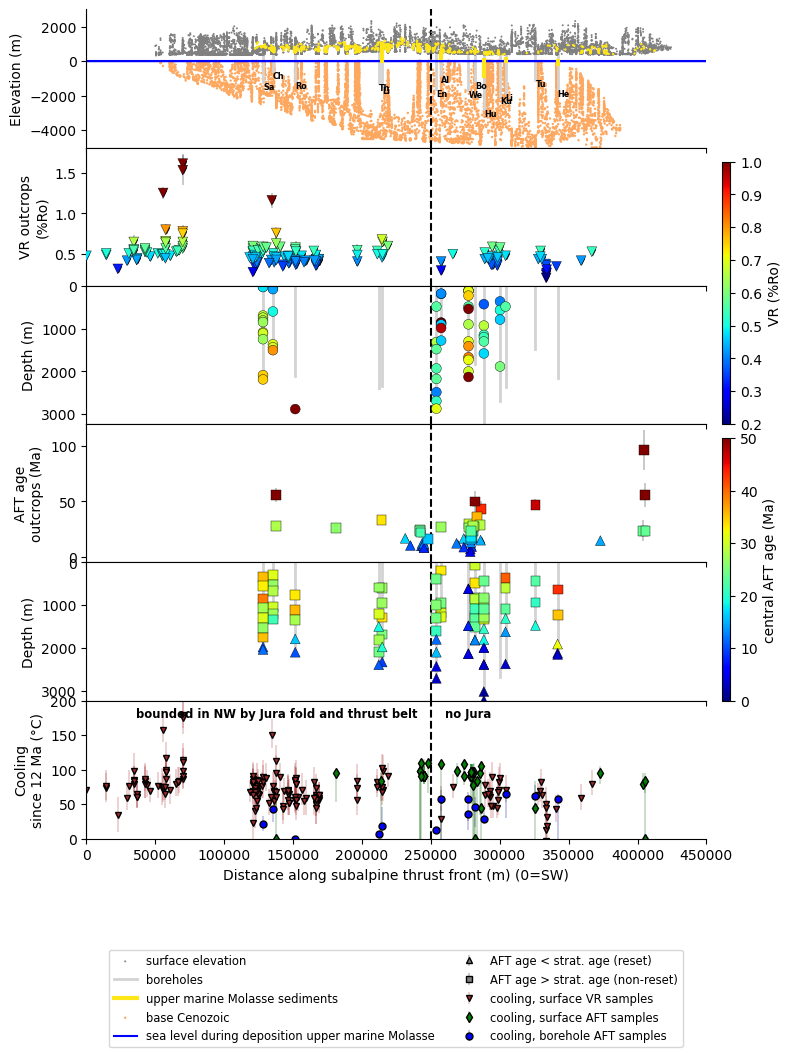

In [17]:
rgb_color = np.array([253., 167., 95.]) / 255

for distance_var in distance_vars:

    fig, panels = pl.subplots(nrows, 1, figsize=(8, nrows * 1.75), sharex='all')

    fig.subplots_adjust(hspace=0.0, wspace=0.0, right=0.9, bottom=0.2, top=0.99)

    #panels_r = [panel.twinx() for panel in panels]

    ind_reset = (df_aft['outcrop_or_borehole'] == 'outcrop') \
                & (df_aft['AFT_reset'] == 'y')
    ind_non_reset = (df_aft['outcrop_or_borehole'] == 'outcrop') \
                    & (df_aft['AFT_reset'] == 'n')


    ##################
    # outcrop VR data
    #################
    ind_outcrop = (df_vr['outcrop_or_borehole'] == 'outcrop') & (df_vr['A'] < 2)

    leg_vr = panels[1].errorbar(df_vr[distance_var][ind_outcrop],
                                df_vr['Rr'][ind_outcrop],
                                yerr=df_vr['s'][ind_outcrop],
                                marker='v', color='black',
                                markerfacecolor='gray', 
                                **errorbar_args)

    leg_vrs = panels[1].scatter(df_vr[distance_var][ind_outcrop],
                                df_vr['Rr'][ind_outcrop],
                                c=df_vr['Rr'][ind_outcrop],
                                marker='v',
                                vmin=vmin_vr, vmax=vmax_vr,
                                zorder=20,
                                **scatter_args)

    ###############################
    # VR values in borehole samples
    ###############################
    leg_vrb = panels[2].scatter(df_vrb[distance_var],
                                df_vrb['depth'],
                                c=df_vrb['VR'],
                                vmin=vmin_vr, vmax=vmax_vr,
                                **scatter_args)

    ######################
    # aft data surface
    #######################
    leg_car = panels[3].errorbar(df_aft[distance_var][ind_reset],
                                 df_aft['AFT_central_age'][ind_reset],
                                 yerr=df_aft['AFT_central_age_stdev'][ind_reset],
                                 marker='^', color='black',
                                 markerfacecolor='gray', **errorbar_args)

    leg_cars = panels[3].scatter(df_aft[distance_var][ind_reset],
                                 df_aft['AFT_central_age'][ind_reset],
                                 c=df_aft['AFT_central_age'][ind_reset],
                                 marker='^',
                                 vmin=vmin_aft, vmax=vmax_aft,
                                 zorder=20,
                                 **scatter_args)

    leg_canr = panels[3].errorbar(df_aft[distance_var][ind_non_reset],
                                  df_aft['AFT_central_age'][ind_non_reset],
                                  yerr=df_aft['AFT_central_age_stdev'][ind_non_reset],
                                  marker='s',
                                  color='black',
                                  markerfacecolor='gray', **errorbar_args)

    leg_canrs = panels[3].scatter(df_aft[distance_var][ind_non_reset],
                                  df_aft['AFT_central_age'][ind_non_reset],
                                  c=df_aft['AFT_central_age'][ind_non_reset],
                                  marker='s',
                                  vmin=vmin_aft, vmax=vmax_aft,
                                  zorder=20,
                                  **scatter_args)

    #######################
    # aft ages boreholes
    #######################
    ind = (df_aft['outcrop_or_borehole'] == 'borehole') & \
          (df_aft['AFT_reset'] == 'n')
    leg_ab_nr = panels[4].scatter(df_aft[distance_var][ind],
                                  df_aft['depth'][ind],
                                  c=df_aft['AFT_central_age'][ind],
                                  vmin=vmin_aft, vmax=vmax_aft,
                                  marker='s',
                                  **scatter_args)

    ind = (df_aft['outcrop_or_borehole'] == 'borehole') & \
          (df_aft['AFT_reset'] == 'y')
    leg_ab_r = panels[4].scatter(df_aft[distance_var][ind],
                                 df_aft['depth'][ind],
                                 c=df_aft['AFT_central_age'][ind],
                                 vmin=vmin_aft, vmax=vmax_aft,
                                 marker='^',
                                 **scatter_args)

    ########################
    # cooling estimates
    ########################
    df_vr['e-'] = df_vr['cooling_surface_vr_best'] - df_vr['cooling_surface_vr_min']
    df_vr['e+'] = df_vr['cooling_surface_vr_max'] - df_vr['cooling_surface_vr_best']
    df_vre = df_vr.dropna(subset=['e-', 'e+'])
    yerr = np.vstack([df_vre['e-'].values, df_vre['e+'].values])

    leg_cool_vrs = panels[5].errorbar(df_vr[distance_var],
                                      df_vr['cooling_surface_vr_best'],
                                      yerr=yerr,
                                      color='brown',
                                      mfc='brown',
                                      marker='v', **errorbar_args)

    #
    df_cool['e-'] = df_cool['cooling_at_est_best'] - df_cool['cooling_at_est_min']
    df_cool['e+'] = df_cool['cooling_at_est_max'] - df_cool['cooling_at_est_best']
    #df_err = df_cool.dropna(subset=['e-', 'e+'])
    df_err = df_cool[['e-', 'e+']]
    yerr = np.vstack([df_err['e-'].values, df_err['e+'].values])

    ind = df_cool['borehole'].notnull()
    leg_cool_borehole = panels[5].errorbar(df_cool[distance_var][ind],
                                           df_cool['cooling_at_est_best'][ind],
                                           yerr=yerr[:, ind.values],
                                           color='darkblue',
                                           mfc='blue',
                                           marker='o',
                                           **errorbar_args)

    ind = df_cool['borehole'].isnull()
    leg_cool_surf = panels[5].errorbar(df_cool[distance_var][ind],
                                       df_cool['cooling_at_est_best'][ind],
                                       yerr=yerr[:, ind.values],
                                       color='darkgreen',
                                       mfc='green', marker='d', **errorbar_args)

    # show cooling/exhumation
    show_drainage_exh = True
    if show_drainage_exh is True:
        if 'perpendicular' in distance_var:
            leg_r, = panels[5].plot(df_river[distance_var],
                                    df_river['cooling'],
                                    color='red',
                                    zorder=1,
                                    lw=1.0)
        else:
            leg_r = None
    else:
        leg_r = None

    # elevation
    if 'perpendicular' in distance_var:
        leg_dem = panels[0].scatter(distances_perpendicular_dem, z_dem,
                                    s=2, color='gray', edgecolor='None', rasterized=True)
    elif 'parallel' in distance_var:
        ind = np.logical_and(distances_perpendicular_dem > -20000,
                             distances_perpendicular_dem < 40000)
        leg_dem = panels[0].scatter(distances_parallel_dem[ind][::thin_dem], z_dem[ind][::thin_dem],
                                    s=2, color='gray', edgecolor='None', rasterized=True)

    # outcrops OMM
    rgb_omm = np.array([255., 230., 25.]) / 255
    if 'perpendicular' in distance_var:
        leg_OMM_outcrops = panels[0].scatter(distances_perpendicular_omm[::thin_dem],
                                             z_dem_omm[::thin_dem],
                                             s=3, color=rgb_omm,
                                             edgecolor='None', rasterized=True)
    elif 'parallel' in distance_var:
        leg_OMM_outcrops = panels[0].scatter(distances_parallel_omm[::thin_dem],
                                             z_dem_omm[::thin_dem],
                                             s=3, color=rgb_omm,
                                             edgecolor='None', rasterized=True)

    # depth basement
    if 'perpendicular' in distance_var:
        leg_cen = panels[0].scatter(distances_perpendicular_cen[::thin_dem], depth_cen_array[::thin_dem],
                                    s=3, color=rgb_color, edgecolor='None',
                                    zorder=0, rasterized=True)

    else:
        leg_cen = panels[0].scatter(distances_parallel_cen[::thin_dem], depth_cen_array[::thin_dem],
                            s=3, color=rgb_color, edgecolor='None',
                            zorder=0, rasterized=True)

    # show OMM and basement rocks in boreholes
    for well in dfb.index:
        if well in df_strat.index:
            df_well = df_strat.loc[well]
            z_well = dfb.loc[well, 'elevation']
            xb = df_well[distance_var].mean()
            zb = df_well['depth_bottom'].max()

            ind_OMM = np.array(['OMM' in s for s in df_well['strat_unit']])

            if True in ind_OMM:
                min_depth_OMM = df_well['depth_top'][ind_OMM].min()
                max_depth_OMM = df_well['depth_bottom'][ind_OMM].max()

                zb = (z_well - min_depth_OMM, z_well - max_depth_OMM)

                print('well %s, OMM from %0.0f to %0.0f' % (well, min_depth_OMM, max_depth_OMM))
                xb = df_well[distance_var].mean()
                leg_OMM, = panels[0].plot((xb, xb), zb,
                                          ls='-', color=rgb_omm,
                                          zorder=30, lw=3.0)

    # show boreholes
    for panel in [panels[2], panels[4]]:
        for xb, md in zip(dfb[distance_var], dfb['max_depth']):
            leg_borehole, = panel.plot((xb, xb), (0, md), **kwargs_borehole)

    # show boreholes in elevation panel
    for panel in [panels[0]]:
        for bname, xb, s, md in zip(dfb.index, dfb[distance_var],
                                    dfb['elevation'], dfb['max_depth']):
            leg_borehole, = panel.plot((xb, xb), (s, s - md),
                                       **kwargs_borehole)
            panel.text(xb, s-md, bname[:2], fontsize='xx-small',
                       va='top', weight='bold')

    # add global sea level range
    panels[0].fill_between([-5e5, 5e5], [10.1, 10.1], y2=[-18, -18],
                           color='blue')
    leg_sl, = panels[0].plot([-5e5, 5e5], [-6.6, -6.6],
                             color='blue')

    # add notation for Jura
    if 'parallel' in distance_var:
        for panel in panels:
            panel.axvline(x=x_jura, color='black', ls='--', zorder=0)

        panels[5].text(x_jura - 1e4, 190.0,
                       'bounded in NW by Jura fold and thrust belt',
                       va='top', ha='right', weight='bold',
                       fontsize='small')
        panels[5].text(x_jura + 1e4, 190.0, 'no Jura',
                       va='top', ha='left', weight='bold',
                       fontsize='small')

    #
    for panel in panels:
        if 'perpendicular' in distance_var:
            panel.set_xlim(-20000, 45000)
        else:
            panel.set_xlim(0, 450000)

        #panel.grid()
        #panel.set_xlabel('Distance to alpine thrust front (m)')
        panel.axvline(x=0, color='gray', zorder=-1)


    legs = [leg_dem, leg_borehole, leg_OMM, leg_cen, leg_sl,
            leg_car, leg_canr, leg_cool_vrs, leg_cool_surf,
            leg_cool_borehole,
            leg_r]

    labels = ['surface elevation', 'boreholes',
              'upper marine Molasse sediments',
              'base Cenozoic',
              'sea level during deposition upper marine Molasse',
              'AFT age < strat. age (reset)',
              'AFT age > strat. age (non-reset)',
              'cooling, surface VR samples',
              'cooling, surface AFT samples',
              'cooling, borehole AFT samples',
              'expected cooling drainage capture\n(Yanites et al., 2013)']

    fig.legend(legs, labels, loc='lower center', ncol=2, fontsize=leg_fs)

    panels[0].set_ylim(-5000, 3000)
    panels[2].set_ylim(dfb['max_depth'].max(), 0)
    panels[4].set_ylim(dfb['max_depth'].max(), 0)
    panels[5].set_ylim(0, 200.0)

    panels[1].set_ylabel('VR outcrops\n(%Ro)')
    panels[2].set_ylabel('Depth (m)')
    panels[3].set_ylabel('AFT age\noutcrops (Ma)')
    panels[4].set_ylabel('Depth (m)')
    panels[0].set_ylabel('Elevation (m)')
    panels[5].set_ylabel('Cooling\nsince 12 Ma (%sC)' % degree_symbol)

    if 'perpendicular' in distance_var:
        panels[-1].set_xlabel('Distance to subalpine thrust front (m)')

    elif 'parallel' in distance_var:
        panels[-1].set_xlabel('Distance along subalpine thrust front (m) '
                              '(0=SW)')

    #panels[1].yaxis.label.set_color('blue')
    #panels[1].tick_params(axis='y', colors='blue')

    x_cb = 0.92
    y_cbs = [panels[2].get_position().y0,
             panels[4].get_position().y0]

    #
    ax_ct = fig.add_axes((0.92, y_cbs[0], 0.01, 0.25))
    ax_cb = fig.add_axes((0.92, y_cbs[1], 0.01, 0.25))
    cb_aft = fig.colorbar(leg_ab_r, cax=ax_cb)
    cb_aft.set_label('central AFT age (Ma)')
    cb_vr = fig.colorbar(leg_vrb, cax=ax_ct)
    cb_vr.set_label('VR (%Ro)')
    
    for ax in panels:
        ax.spines['right'].set_visible(False)
    panels[0].spines['top'].set_visible(False)
        

    #fig.tight_layout()

    #useful_functions.make_subplot_titles(panels)

    print('saving figure to subdirectory fig')

    if 'perpendicular' in distance_var:
        fig.savefig("fig/thermochron_profile.png", dpi=200)
        fig.savefig("fig/thermochron_profile.svg")

    elif 'parallel' in distance_var:
        fig.savefig("fig/thermochron_profile_parallel.png", dpi=200)
        fig.savefig("fig/thermochron_profile_parallel.svg")

## Same figure, but with cooling estimates only 

well Altishofen, OMM from 25 to 322
well Chapelle, OMM from 17 to 112
well Herdern, OMM from 490 to 697
well Huenenberg, OMM from 372 to 1340
well Lindau, OMM from 400 to 515
well Linden, OMM from 27 to 888
well Romanens, OMM from 174 to 366
saving figure to subdirectory fig
well Altishofen, OMM from 25 to 322
well Chapelle, OMM from 17 to 112
well Herdern, OMM from 490 to 697
well Huenenberg, OMM from 372 to 1340
well Lindau, OMM from 400 to 515
well Linden, OMM from 27 to 888
well Romanens, OMM from 174 to 366
saving figure to subdirectory fig


/var/folders/gq/fj_xhcmn3yg3gtst5_qj3drr0000gn/T/ipykernel_62707/2489417481.py:191: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(legs, labels, loc='lower center', ncol=2, fontsize=leg_fs)


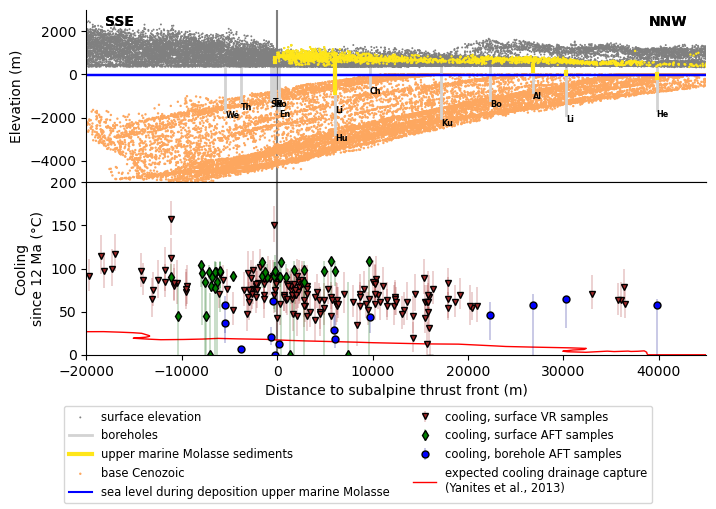

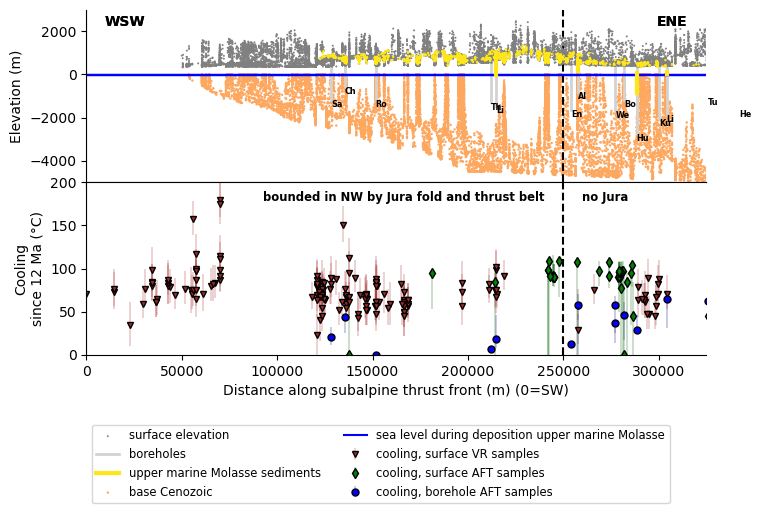

In [18]:
thin_dem = 1

for distance_var in distance_vars:
    
    fig, panels = pl.subplots(2, 1, figsize=(8, 5), sharex='all')

    fig.subplots_adjust(hspace=0.0, wspace=0.0, right=0.9, bottom=0.3, top=0.99)

    #panels_r = [panel.twinx() for panel in panels]

    ind_reset = (df_aft['outcrop_or_borehole'] == 'outcrop') \
                & (df_aft['AFT_reset'] == 'y')
    ind_non_reset = (df_aft['outcrop_or_borehole'] == 'outcrop') \
                    & (df_aft['AFT_reset'] == 'n')

    ########################
    # cooling estimates
    ########################
    ax = panels[-1]

    df_vr['e-'] = df_vr['cooling_surface_vr_best'] - df_vr['cooling_surface_vr_min']
    df_vr['e+'] = df_vr['cooling_surface_vr_max'] - df_vr['cooling_surface_vr_best']
    df_vre = df_vr.dropna(subset=['e-', 'e+'])
    yerr = np.vstack([df_vre['e-'].values, df_vre['e+'].values])

    leg_cool_vrs = ax.errorbar(df_vr[distance_var],
                                      df_vr['cooling_surface_vr_best'],
                                      yerr=yerr,
                                      color='brown',
                                      mfc='brown',
                                      marker='v', **errorbar_args)

    #
    df_cool['e-'] = df_cool['cooling_at_est_best'] - df_cool['cooling_at_est_min']
    df_cool['e+'] = df_cool['cooling_at_est_max'] - df_cool['cooling_at_est_best']
    #df_err = df_cool.dropna(subset=['e-', 'e+'])
    df_err = df_cool[['e-', 'e+']]
    yerr = np.vstack([df_err['e-'].values, df_err['e+'].values])

    ind = df_cool['borehole'].notnull()
    leg_cool_borehole = ax.errorbar(df_cool[distance_var][ind],
                                           df_cool['cooling_at_est_best'][ind],
                                           yerr=yerr[:, ind.values],
                                           color='darkblue',
                                           mfc='blue',
                                           marker='o',
                                           **errorbar_args)

    ind = df_cool['borehole'].isnull()
    leg_cool_surf = ax.errorbar(df_cool[distance_var][ind],
                                       df_cool['cooling_at_est_best'][ind],
                                       yerr=yerr[:, ind.values],
                                       color='darkgreen',
                                       mfc='green', marker='d', **errorbar_args)

    # show cooling/exhumation
    show_drainage_exh = True
    if show_drainage_exh is True:
        if 'perpendicular' in distance_var:
            leg_r, = ax.plot(df_river[distance_var], df_river['cooling'],
                             color='red', zorder=1, lw=1.0)
        else:
            leg_r = None
    else:
        leg_r = None

    # elevation
    ax = panels[0]

    if 'perpendicular' in distance_var:
        leg_dem = ax.scatter(distances_perpendicular_dem, z_dem,
                                    s=2, color='gray', edgecolor='None', rasterized=True)
    elif 'parallel' in distance_var:
        ind = np.logical_and(distances_perpendicular_dem > -20000,
                             distances_perpendicular_dem < 40000)
        leg_dem = ax.scatter(distances_parallel_dem[ind][::thin_dem], z_dem[ind][::thin_dem],
                                    s=2, color='gray', edgecolor='None', rasterized=True)

    # outcrops OMM
    rgb_omm = np.array([255., 230., 25.]) / 255
    if 'perpendicular' in distance_var:
        leg_OMM_outcrops = ax.scatter(distances_perpendicular_omm[::thin_dem],
                                             z_dem_omm[::thin_dem],
                                             s=3, color=rgb_omm,
                                             edgecolor='None', rasterized=True)
    elif 'parallel' in distance_var:
        leg_OMM_outcrops = ax.scatter(distances_parallel_omm[::thin_dem],
                                             z_dem_omm[::thin_dem],
                                             s=3, color=rgb_omm,
                                             edgecolor='None', rasterized=True)

    # depth basement
    if 'perpendicular' in distance_var:
        rgb_color = np.array([253., 167., 95.]) / 255

        leg_cen = ax.scatter(distances_perpendicular_cen[::thin_dem], depth_cen_array[::thin_dem],
                                    s=3, color=rgb_color, edgecolor='None',
                                    zorder=0, rasterized=True)
    else:
        thin_dem = 1
        leg_cen = ax.scatter(distances_parallel_cen[::thin_dem], depth_cen_array[::thin_dem],
                             s=3, color=rgb_color, edgecolor='None',
                             zorder=0, rasterized=True)

    # show OMM and basement rocks in boreholes
    for well in dfb.index:
        if well in df_strat.index:
            df_well = df_strat.loc[well]
            z_well = dfb.loc[well, 'elevation']
            xb = df_well[distance_var].mean()
            zb = df_well['depth_bottom'].max()

            ind_OMM = np.array(['OMM' in s for s in df_well['strat_unit']])

            if True in ind_OMM:
                min_depth_OMM = df_well['depth_top'][ind_OMM].min()
                max_depth_OMM = df_well['depth_bottom'][ind_OMM].max()

                zb = (z_well - min_depth_OMM, z_well - max_depth_OMM)

                print('well %s, OMM from %0.0f to %0.0f' % (well, min_depth_OMM, max_depth_OMM))
                xb = df_well[distance_var].mean()
                leg_OMM, = ax.plot((xb, xb), zb,
                                    ls='-', color=rgb_omm,
                                    zorder=30, lw=3.0)

    # show boreholes in elevation panel
    for panel in [panels[0]]:
        for bname, xb, s, md in zip(dfb.index, dfb[distance_var],
                                    dfb['elevation'], dfb['max_depth']):
            leg_borehole, = panel.plot((xb, xb), (s, s - md),
                                       **kwargs_borehole)
            panel.text(xb, s-md, bname[:2], fontsize='xx-small',
                       va='top', weight='bold')

    # add global sea level range
    panels[0].fill_between([-5e5, 5e5], [10.1, 10.1], y2=[-18, -18],
                           color='blue')
    leg_sl, = panels[0].plot([-5e5, 5e5], [-6.6, -6.6],
                             color='blue')

    # add notation for Jura
    if 'parallel' in distance_var:
        for panel in panels:
            panel.axvline(x=x_jura, color='black', ls='--', zorder=0)

        panels[-1].text(x_jura - 1e4, 190.0,
                       'bounded in NW by Jura fold and thrust belt',
                       va='top', ha='right', weight='bold',
                       fontsize='small')
        panels[-1].text(x_jura + 1e4, 190.0, 'no Jura',
                       va='top', ha='left', weight='bold',
                       fontsize='small')
        
        panels[0].text(0.03, 0.97, 'WSW', transform=panels[0].transAxes, 
                       ha='left', va='top', weight='bold')
        panels[0].text(0.97, 0.97, 'ENE', transform=panels[0].transAxes, 
                       ha='right', va='top', weight='bold')
    
    elif 'perpendicular' in distance_var:
        panels[0].text(0.03, 0.97, 'SSE', transform=panels[0].transAxes, 
                       ha='left', va='top', weight='bold')
        panels[0].text(0.97, 0.97, 'NNW', transform=panels[0].transAxes, 
                       ha='right', va='top', weight='bold')
    #
    for panel in panels:
        if 'perpendicular' in distance_var:
            panel.set_xlim(-20000, 45000)
        else:
            panel.set_xlim(0, 450000)

        #panel.grid()
        #panel.set_xlabel('Distance to alpine thrust front (m)')
        panel.axvline(x=0, color='gray', zorder=-1)


    legs = [leg_dem, leg_borehole, leg_OMM, leg_cen, leg_sl,
            leg_cool_vrs, leg_cool_surf,
            leg_cool_borehole,
            leg_r]

    labels = ['surface elevation', 'boreholes',
              'upper marine Molasse sediments',
              'base Cenozoic',
              'sea level during deposition upper marine Molasse',
              'cooling, surface VR samples',
              'cooling, surface AFT samples',
              'cooling, borehole AFT samples',
              'expected cooling drainage capture\n(Yanites et al., 2013)']

    fig.legend(legs, labels, loc='lower center', ncol=2, fontsize=leg_fs)

    panels[0].set_ylim(-5000, 3000)
    panels[-1].set_ylim(0, 200.0)

    panels[0].set_ylabel('Elevation (m)')
    panels[-1].set_ylabel('Cooling\nsince 12 Ma (%sC)' % degree_symbol)

    if 'parallel' in distance_var:
        panels[-1].set_xlim(0, 325000)
        panels[0].text(0.03, 0.97, 'WSW', transform=panels[0].transAxes, 
                       ha='left', va='top', weight='bold')
        panels[0].text(0.97, 0.97, 'ENE', transform=panels[0].transAxes, 
                       ha='right', va='top', weight='bold')
    
    elif 'perpendicular' in distance_var:
        panels[0].text(0.03, 0.97, 'SSE', transform=panels[0].transAxes, 
                       ha='left', va='top', weight='bold')
        panels[0].text(0.97, 0.97, 'NNW', transform=panels[0].transAxes, 
                       ha='right', va='top', weight='bold')
        
    
    if 'perpendicular' in distance_var:
        panels[-1].set_xlabel('Distance to subalpine thrust front (m)')

    elif 'parallel' in distance_var:
        panels[-1].set_xlabel('Distance along subalpine thrust front (m) '
                              '(0=SW)')

    #panels[1].yaxis.label.set_color('blue')
    #panels[1].tick_params(axis='y', colors='blue')

    #useful_functions.make_subplot_titles(panels)
    panels[0].spines['top'].set_visible(False)
        
    for ax in panels:
        ax.spines['right'].set_visible(False)

    print('saving figure to subdirectory fig')

    if 'perpendicular' in distance_var:
        fig.savefig("fig/cooling_profile.png", dpi=200)
        fig.savefig("fig/cooling_profile.svg")

    elif 'parallel' in distance_var:
        fig.savefig("fig/cooling_profile_parallel.png", dpi=200)
        fig.savefig("fig/cooling_profile_parallel.svg")